In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Large Wheat classification detection"

'Crown and Root Rot'  'Healthy Wheat'  'Leaf Rust'  'Wheat Loose Smut'


In [ ]:
!pip install tensorflow

In [ ]:


from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import classification_report
from keras.applications import VGG19
from imutils import paths
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle

In [ ]:
dataset = "/content/drive/MyDrive/Large Wheat classification detection"
label = "lb.pickle"
LABELS = set(["Crown and Root Rot", "Healthy Wheat", "Leaf Rust", "Wheat Loose Smut"])

In [ ]:
sample_path = list(paths.list_images('/content/drive/MyDrive/Large Wheat classification detection/Crown and Root Rot'))[0]
sample_path.split('/')
Labels = os.listdir('/content/drive/MyDrive/Large Wheat classification detection')
CROWN_AND_ROOT_ROT_PATH = '/content/drive/MyDrive/Large Wheat classification detection/Crown and Root Rot'
HEALTHY_AND_WHEAT_PATH = '/content/drive/MyDrive/Large Wheat classification detection/Healthy Wheat'
LEAF_RUST_PATH = '/content/drive/MyDrive/Large Wheat classification detection/Leaf Rust'
WHEAT_LOOSE_SMUT_PATH = '/content/drive/MyDrive/Large Wheat classification detection/Wheat Loose Smut'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = []
labels = []
for image_path in tqdm(paths.list_images(CROWN_AND_ROOT_ROT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)

    label = image_path.split('/')[-2]
    labels.append(label)

for image_path in tqdm(paths.list_images(HEALTHY_AND_WHEAT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)

    label = image_path.split('/')[-2]
    labels.append(label)

for image_path in tqdm(paths.list_images(LEAF_RUST_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)

    label = image_path.split('/')[-2]
    labels.append(label)

for image_path in tqdm(paths.list_images(WHEAT_LOOSE_SMUT_PATH)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)

    label = image_path.split('/')[-2]
    labels.append(label)

1021it [00:37, 27.08it/s]
1146it [01:33, 12.25it/s]
1223it [03:44,  5.44it/s]
930it [00:47, 19.42it/s] 


In [ ]:
print(len(labels))

4320


In [ ]:
labels

['Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and Root Rot',
 'Crown and

In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
 test_size=0.25, stratify=labels, random_state=42)

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
 rotation_range=30,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:
headmodel = VGG19(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (224, 224, 3)))
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.2)(model)
model = Dense(len(Labels), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

for layer in headmodel.layers:
    layer.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
final_model.compile(loss="categorical_crossentropy", optimizer='adam',
               metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
H = final_model.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=30)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4818 - loss: 2.9279 - val_accuracy: 0.7207 - val_loss: 0.9945
Epoch 2/30
 1/50 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.6406 - loss: 1.4673

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6406 - loss: 1.4673 - val_accuracy: 0.7090 - val_loss: 1.0321
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 886ms/step - accuracy: 0.6921 - loss: 1.0153 - val_accuracy: 0.7500 - val_loss: 0.7375
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7656 - loss: 0.7095 - val_accuracy: 0.7598 - val_loss: 0.7161
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 890ms/step - accuracy: 0.7525 - loss: 0.7122 - val_accuracy: 0.7930 - val_loss: 0.6429
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7812 - loss: 0.6196 - val_accuracy: 0.7910 - val_loss: 0.5997
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 876ms/step - accuracy: 0.7670 - loss: 0.6529 - val_accuracy: 0.7930 - val_loss: 0.5863
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7500 - loss: 0.6573 - val_accuracy: 0.7930 - val_loss: 0.5655
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 891ms/step - accuracy: 0.8021 - loss: 0.5451 - val_accuracy: 0.8066 - val_

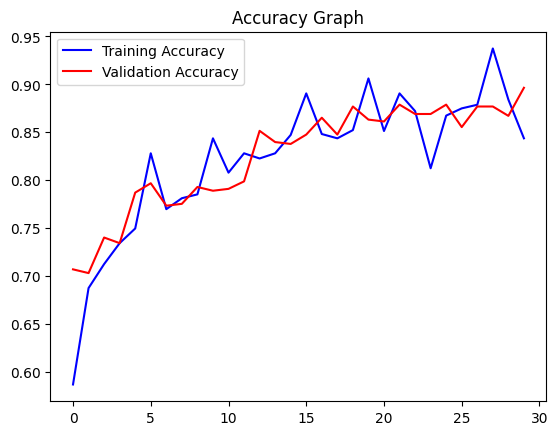

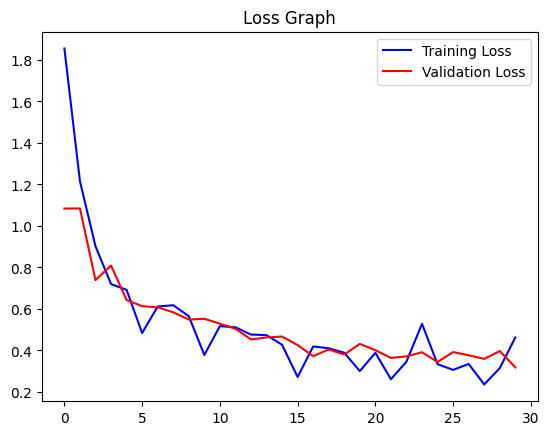

In [ ]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = H.history['loss']
val_loss = H.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 563ms/step


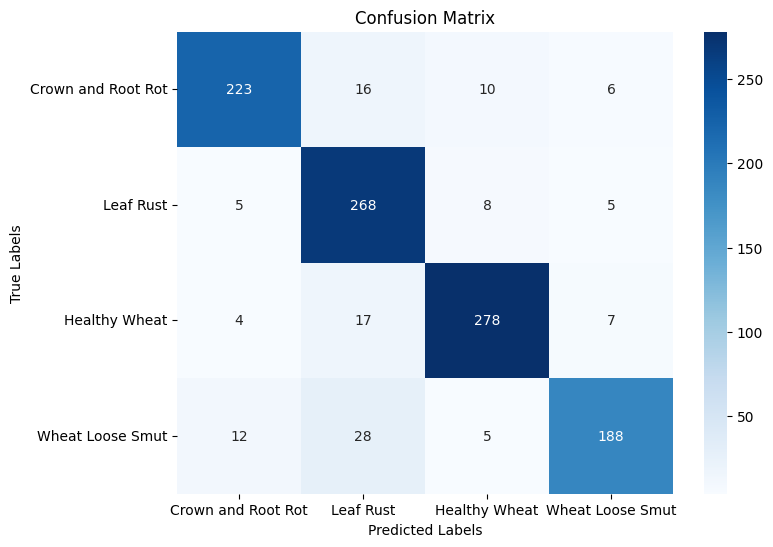

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the true labels in 'true_labels' and the predicted labels in 'predicted_labels'
true_labels = np.argmax(testY, axis=1)  # Assuming labels are one-hot encoded
predicted_labels = np.argmax(final_model.predict(testX), axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Labels, yticklabels=Labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
